<h1><center> Kaggle Competition: [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction)</center></h1> 

# 1. Data Ingestion & Data Cleaning

## 1.1 Data Ingestion

In [1]:
import math
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import subprocess
import seaborn as sns
sns.set()

import time
start_time = time.time()

In [2]:
# train_rows = 55423857
# print (f'>>> Exact number of rows: {train_rows}')

try:
    train_df = pd.read_csv('data/train.csv', nrows=5)
except FileNotFoundError:
    print('>>> You must download train.csv from: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/download/train.csv')

### Decrease memory footprint

In [3]:
# set column types to optimize memory usage
col_types = {
    'fare_amount': 'float32',
    'pickup_datetime': 'str', 
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'passenger_count': 'uint8'
}

new_cols = list(col_types.keys())

In [4]:
def get_raw_dataframe(read_size=0):   
    # Method #1: read the entire DataFrame from the disk
    if (read_size == 0):
        df_list = [] # list to hold the batch dataframe
        for df_chunk in tqdm(pd.read_csv('data/train.csv', usecols=new_cols, dtype=col_types, chunksize=5000000)): # loads 5M rows each iteration
            df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
            df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

            # Can process each chunk of dataframe here
            # clean_data(), feature_engineer(),fit()

            # Alternatively, append the chunk to list and merge all
            df_list.append(df_chunk) 

        # merge all dataframes into one
        train_df = pd.concat(df_list)
        del df_list
        return train_df
        
    # Method #2: read a predetermined amount of data         
    train_df = pd.read_csv('data/train.csv', usecols=new_cols, dtype=col_types, nrows=read_size)
    train_df['pickup_datetime'] = train_df['pickup_datetime'].str.slice(0, 16)
    train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    return train_df

In [5]:
# train_df.info(memory_usage='deep')

## 1.2 Data Cleaning

In [6]:
# check feature statistics
pd.set_option('float_format', '{:f}'.format) # prints the entire number instead of x + ye
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,8.020000,-73.959664,40.739009,-73.952068,40.757340,1.200000
std,5.102156,0.066789,0.024756,0.063357,0.029084,0.447214
min,4.500000,-74.016048,40.711303,-73.991567,40.712278,1.000000
25%,5.300000,-73.987130,40.721319,-73.991242,40.750562,1.000000
50%,5.700000,-73.982738,40.733143,-73.979268,40.758092,1.000000
75%,7.700000,-73.968095,40.761270,-73.956655,40.782004,1.000000
max,16.900000,-73.844311,40.768008,-73.841610,40.783762,2.000000


In [7]:
def get_clean_dataframe(num_rows):
    train_df = get_raw_dataframe(num_rows)
    
    # remove NaNs and Negative & Free fares (keeping only the ones that cost more than 0)
    train_df.dropna(inplace=True, axis=0)
    train_df = train_df[train_df['fare_amount'] > 0]

    # remove rows where lat/long are ZERO
    train_df = train_df[(train_df['pickup_latitude'] != 0) & (train_df['pickup_longitude'] != 0)]
    train_df = train_df[(train_df['dropoff_latitude'] != 0) & (train_df['dropoff_longitude'] != 0)]

    # handle rides with too many or too few passengers
    train_df = train_df[(train_df['passenger_count'] > 0) & (train_df['passenger_count'] <= 7)]
    return train_df

# 2. Feature Engineering

In [8]:
# Distance formula: https://www.movable-type.co.uk/scripts/latlong.html
def getDistance(lat1, lon1, lat2, lon2): 
    R = 6371e3
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    deltaPhi = math.radians(lat2-lat1)
    deltaLambda = math.radians(lon2-lon1)

    a = math.sin(deltaPhi/2) * math.sin(deltaPhi/2) + math.cos(phi1) * math.cos(phi2) * math.sin(deltaLambda/2) * math.sin(deltaLambda/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return round((R * c) / 1000, 3)    # returns distance in km

In [9]:
# Add calendar related features: year, month, day, hour, day_of_week
def add_calendar(df):
    df['year'] = df.pickup_datetime.apply(lambda x: x.year)
    df['month'] = df.pickup_datetime.apply(lambda x: x.month)
    df['day'] = df.pickup_datetime.apply(lambda x: x.day)
    df['hour'] = df.pickup_datetime.apply(lambda x: x.hour)
    df['day_of_week'] = df.pickup_datetime.apply(lambda x: x.weekday())

    df['year'] = df['year'].astype('int16')
    df['month'] = df['month'].astype('int8')
    df['day'] = df['day'].astype('int8')
    df['hour'] = df['hour'].astype('int8')
    df['day_of_week'] = df['day_of_week'].astype('int8')    
    return df

In [10]:
# Add distance in kilometers
def add_distance(df):
    df['distance_km'] = df.apply(lambda row: getDistance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    df['distance_km'] = df['distance_km'].astype('float32')

    df['distance_km_round'] = df.distance_km.apply(lambda x: int(round(x)))
    df['distance_km_round'] = df['distance_km_round'].astype('int16')
    return df

In [11]:
# Add geographical feature 
def add_geo_feature(df):
    df['lon_diff'] = df['dropoff_longitude'] - df['pickup_longitude']
    df['lat_diff'] = df['dropoff_latitude']  - df['pickup_latitude']
    return df

In [12]:
# Add number of taxis per hour (only works for the training set)
def add_taxis_per_hour(df):
    tmp = df.groupby(['year','month','day']).agg({'hour' : [np.size]}).reset_index()
    tmp.columns = ['year','month','day','taxis_per_hour']
    df = pd.merge(df, tmp, how='left', on=['year','month','day'])
    df['taxis_per_hour'] = df['taxis_per_hour'].astype('float32')
    return df

In [13]:
# Add mean/median/min/max fare (only works for the training set)
def add_fare_statistics(df):
    tmp = df.groupby(['year','month','day_of_week','hour','distance_km_round','taxis_per_hour']).agg({'fare_amount' : [np.mean,np.median,np.min,np.max]}).reset_index()
    tmp.columns = ['year','month','day_of_week','hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']
    df = pd.merge(df, tmp, how='left', on=['year','month','day_of_week','hour','distance_km_round','taxis_per_hour']) 
    return df

In [14]:
# Add Cost per KM (only works for the training set)
def add_cost_per_km(df):
    df['cost_per_km'] = df.apply(lambda row: row['distance_km_round'] / row['fare_amount'], axis=1)
    df['cost_per_km'] = df['cost_per_km'].astype('float32')
    return df

# 3. Model Training

In [15]:
%%time

# train_df = get_clean_dataframe(2000000) # loads 2M rows
train_df = get_clean_dataframe(4000000) # loads 4M rows

train_df = add_calendar(train_df)
train_df = add_distance(train_df)
train_df = add_geo_feature(train_df)
train_df = add_taxis_per_hour(train_df)
train_df = add_fare_statistics(train_df)
train_df = add_cost_per_km(train_df)

train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3906149 entries, 0 to 3906148
Data columns (total 22 columns):
fare_amount          float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
year                 int16
month                int8
day                  int8
hour                 int8
day_of_week          int8
distance_km          float32
distance_km_round    int16
lon_diff             float32
lat_diff             float32
taxis_per_hour       float32
mean_fare            float32
median_fare          float32
min_fare             float32
max_fare             float32
cost_per_km          float32
dtypes: datetime64[ns, UTC](1), float32(14), int16(2), int8(4), uint8(1)
memory usage: 301.7 MB
Wall time: 11min 45s


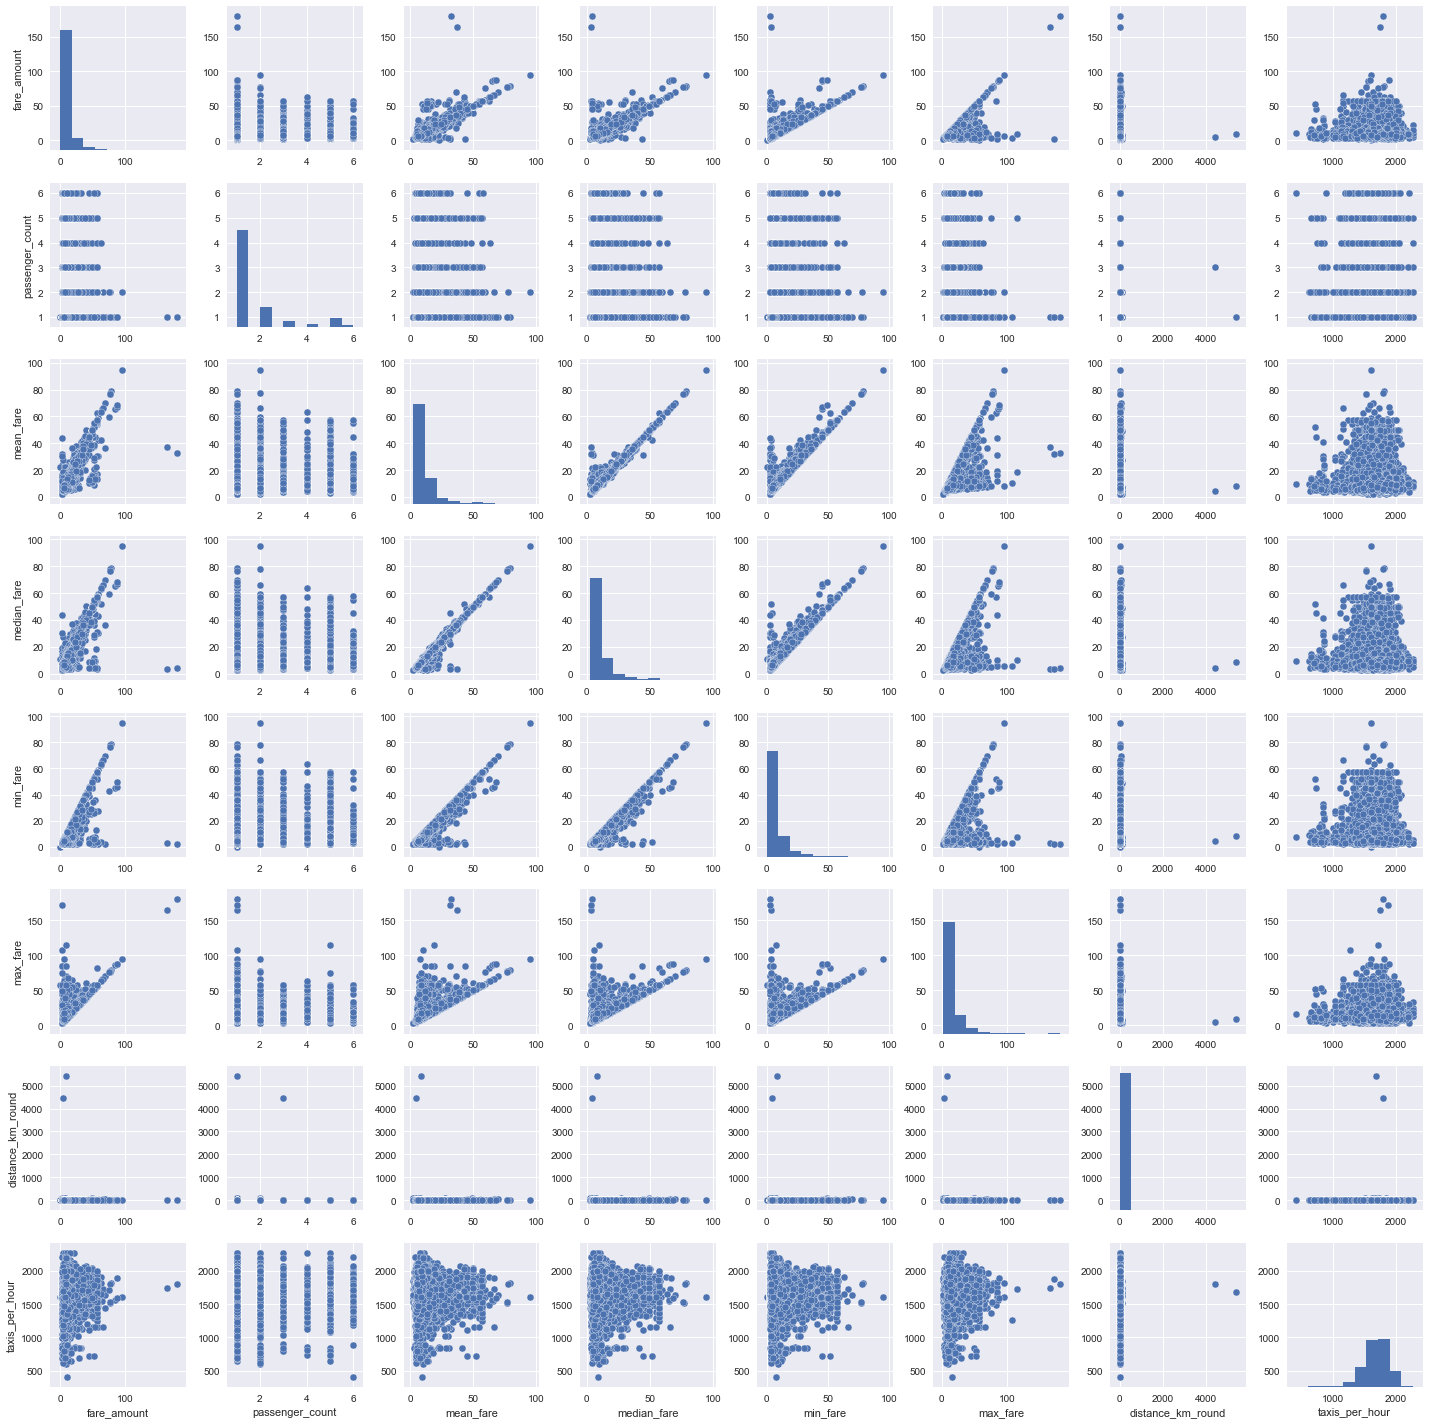

In [16]:
train_subset = train_df[:10000]
sns.pairplot(train_subset, vars=['fare_amount','passenger_count','mean_fare','median_fare','min_fare','max_fare','distance_km_round','taxis_per_hour'])
plt.show()

In [17]:
pd.set_option('float_format', '{:f}'.format) # prints the entire number instead of x + ye
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,...,distance_km,distance_km_round,lon_diff,lat_diff,taxis_per_hour,mean_fare,median_fare,min_fare,max_fare,cost_per_km
count,3906149.000000,3906149.000000,3906149.000000,3906149.000000,3906149.000000,3906149.000000,3906149.000000,3906149.000000,3906149.000000,3906149.000000,...,3906149.000000,3906149.000000,3906149.000000,3906149.000000,3906149.000000,3906149.000000,3906149.000000,3906149.000000,3906149.000000,3906149.000000
mean,11.313065,-74.900169,41.169334,-74.898438,41.166573,1.690420,2011.737705,6.268629,15.718602,13.513625,...,4.618678,4.619978,0.002324,-0.001984,1675.752686,11.325154,10.909179,8.698681,16.409109,0.441366
std,9.689796,8.264273,6.626467,8.044493,7.881962,1.305928,1.865053,3.435198,8.684451,6.515257,...,86.008835,86.081891,9.500594,8.359720,203.844345,9.040921,9.096402,9.167131,11.305315,12.364076
min,0.010000,-3426.608887,-3488.079590,-3412.653076,-3488.079590,1.000000,2009.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,-6354.358887,-5501.513672,95.000000,0.010000,0.010000,0.010000,0.010000,0.000000
25%,6.000000,-73.992279,40.736492,-73.991577,40.735508,1.000000,2010.000000,3.000000,8.000000,9.000000,...,1.254000,1.000000,-0.011505,-0.014030,1569.000000,6.327586,6.000000,4.000000,10.100000,0.198020
50%,8.500000,-73.982094,40.753315,-73.980598,40.753826,1.000000,2012.000000,6.000000,16.000000,14.000000,...,2.154000,2.000000,0.000877,0.000000,1699.000000,8.520000,8.100000,5.500000,13.300000,0.266150
75%,12.500000,-73.968285,40.767525,-73.965286,40.768402,2.000000,2013.000000,9.000000,23.000000,19.000000,...,3.916000,4.000000,0.013901,0.014309,1819.000000,12.380000,11.950000,9.000000,18.100000,0.342857
max,542.830017,3439.425537,2912.464600,3457.622314,3345.917236,6.000000,2015.000000,12.000000,31.000000,23.000000,...,19108.796875,19109.000000,5472.153320,4346.694336,2271.000000,495.000000,495.000000,495.000000,542.830017,3024.390381


In [18]:
%%time

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_regression, RFECV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from itertools import compress

target = train_df[['fare_amount']]
df = train_df.drop(['fare_amount', 'pickup_datetime'], axis=1)

X = df
y = target.values.ravel()

# Split X,y into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('>>> Train/Test Split done!')

# Create the 1st model using GradientBoostingRegressor
# gbr_model = GradientBoostingRegressor(n_estimators=25, random_state=7, learning_rate=0.1, max_depth=7) # with log1p/expm1: 0.514
# gbr_model.fit(X_train, np.log1p(y_train))
# print('>>> Model1 Training done!')

# Create the 2nd model using RandomForestRegressor
rfr_model = RandomForestRegressor(n_jobs=6, n_estimators=25, max_features=len(df.columns), max_depth=25, min_samples_split=3, min_samples_leaf=3, random_state=42)
rfr_model.fit(X_train, np.log1p(y_train))
print('>>> Model2 Training done!')

>>> Train/Test Split done!
>>> Model2 Training done!
Wall time: 4min 8s


# 4. Model Evaluation


>>> RMSE Score: 1.784987975481238 



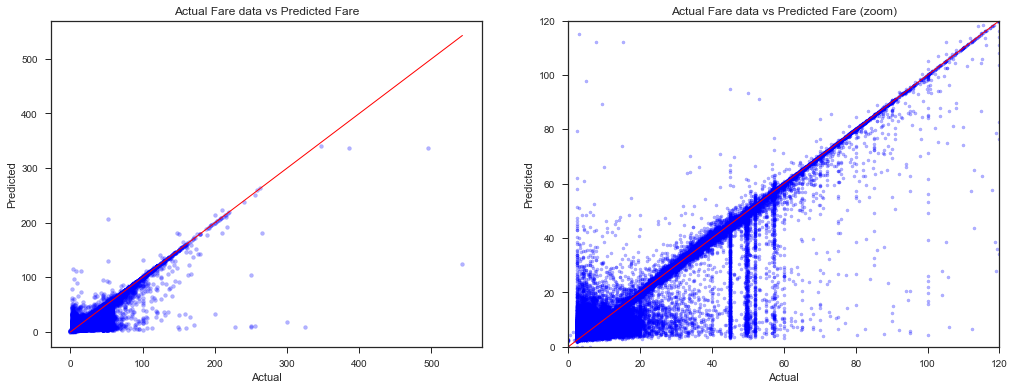

Wall time: 14.9 s


In [19]:
%%time

from lib import gfx  # gfx is another local module under the 'lib' directory
from sklearn import metrics
from math import sqrt

# The prediction is calculated as the arithmetic mean of both model's predictions
# gbr_fare = np.expm1(gbr_model.predict(X_test))  # model 1
rfr_fare = np.expm1(rfr_model.predict(X_test))   # model 2

# y_pred = (gbr_visitors + rfr_visitors) / 2
# y_pred = gbr_fare
y_pred = rfr_fare

rmse_score = sqrt(metrics.mean_squared_error(y_test, y_pred))
print('\n>>> RMSE Score:', rmse_score, '\n') # 1.669

# Plot Actual FARE data against Predicted fare
gfx.plot_actual_vs_predicted(y, y_test, y_pred)

# 5. Submission

### Feature Engineering for the Test dataset

In [20]:
# Add taxis_per_hour feature for the test set
def test_add_taxis_per_hour(test, train):
    short_train_df = train[['year','month','day','hour','taxis_per_hour']]
    tmp = short_train_df.groupby(['year','month','day','hour']).agg({'taxis_per_hour' : [np.mean]}).reset_index()
    tmp.columns = ['year','month','day','hour','taxis_per_hour']

    test = pd.merge(test, tmp, how='left', on=['year','month','day','hour'])  
    return test

In [27]:
# Add mean/median/min/max fare statistics for the test set
# ORIG CODE FOR TRAIN_DF
# tmp = df.groupby(['year','month','day_of_week','hour','distance_km_round','taxis_per_hour']).agg({'fare_amount' : [np.mean,np.median,np.min,np.max]}).reset_index()
# tmp.columns = ['year','month','day_of_week','hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']
# df = pd.merge(df, tmp, how='left', on=['year','month','day_of_week','hour','distance_km_round','taxis_per_hour']) 

def test_add_statistics(test, train):
    # Score 7.82    
#     short_train_df = train[['year','month','day_of_week','hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']]
#     tmp = short_train_df.groupby(['year','month','day_of_week','hour','distance_km_round','taxis_per_hour']).agg({'mean_fare':[np.mean],'median_fare':[np.mean],'min_fare':[np.mean],'max_fare':[np.mean]}).reset_index()
#     tmp.columns = ['year','month','day_of_week','hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']    
#     test = pd.merge(test, tmp, how='left', on=['year','month','day_of_week','hour','distance_km_round','taxis_per_hour'])          

    # Score 6.59
#     short_train_df = train[['hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']]
#     tmp = short_train_df.groupby(['hour','distance_km_round','taxis_per_hour']).agg({'mean_fare':[np.mean],'median_fare':[np.mean],'min_fare':[np.mean],'max_fare':[np.mean]}).reset_index()
#     tmp.columns = ['hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']
#     test = pd.merge(test, tmp, how='left', on=['hour','distance_km_round','taxis_per_hour'])  

    # Score 7.58
    short_train_df = train[['day_of_week','hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']]
    tmp = short_train_df.groupby(['day_of_week','hour','distance_km_round','taxis_per_hour']).agg({'mean_fare':[np.mean],'median_fare':[np.mean],'min_fare':[np.mean],'max_fare':[np.mean]}).reset_index()
    tmp.columns = ['day_of_week','hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']
    test = pd.merge(test, tmp, how='left', on=['day_of_week','hour','distance_km_round','taxis_per_hour'])  
    
    return test

In [22]:
def test_add_cost_per_km(test):    
    test['cost_per_km'] = test.apply(lambda row: row['distance_km_round'] / row['mean_fare'], axis=1)
    test['cost_per_km'] = test['cost_per_km'].astype('float32')
    return test

### Load test data and add new features

In [23]:
# loads a sample submission file in the correct format (columns key and fare_amount). 
submission_df = pd.read_csv('data/sample_submission.csv')
# display(submission_df.head(2))

# loads the test dataset used for submission
test_df = pd.read_csv('data/test.csv')

display(test_df.head(3))
print('>>> test_df shape:', test_df.shape)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1


>>> test_df shape: (9914, 7)


In [24]:
# Add common features
test_df['pickup_datetime'] = test_df['pickup_datetime'].str.slice(0, 16)
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

test_df = add_calendar(test_df)
test_df = add_distance(test_df)
test_df = add_geo_feature(test_df)

display(test_df.head())

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,distance_km,distance_km_round,lon_diff,lat_diff
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:00+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,13,1,2.323000,2,-0.008110,-0.019970
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:00+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,13,1,2.425000,2,-0.012024,0.019817
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:00+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,11,5,0.619000,1,0.002870,-0.005121
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:00+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,21,5,1.961000,2,-0.009288,-0.016172
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:00+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,21,5,5.387000,5,-0.022519,-0.045348


In [25]:
test_df = test_add_taxis_per_hour(test_df, train_df)        
display(test_df.head())

# Check missing data
print(test_df.isnull().sum())
test_df = test_df.fillna(test_df.mean())

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,distance_km,distance_km_round,lon_diff,lat_diff,taxis_per_hour
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:00+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,13,1,2.323000,2,-0.008110,-0.019970,495.000000
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:00+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,13,1,2.425000,2,-0.012024,0.019817,495.000000
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:00+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,11,5,0.619000,1,0.002870,-0.005121,1902.000000
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:00+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,21,5,1.961000,2,-0.009288,-0.016172,2052.000000
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:00+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,21,5,5.387000,5,-0.022519,-0.045348,2052.000000


key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
year                 0
month                0
day                  0
hour                 0
day_of_week          0
distance_km          0
distance_km_round    0
lon_diff             0
lat_diff             0
taxis_per_hour       0
dtype: int64


In [28]:
test_df = test_add_statistics(test_df, train_df)        
display(test_df.head())

# Check missing data
print(test_df.isnull().sum())
test_df = test_df.fillna(test_df.mean())

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,...,day_of_week,distance_km,distance_km_round,lon_diff,lat_diff,taxis_per_hour,mean_fare,median_fare,min_fare,max_fare
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:00+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,...,1,2.323000,2,-0.008110,-0.019970,495.000000,7.666667,7.500000,6.000000,9.500000
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:00+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,...,1,2.425000,2,-0.012024,0.019817,495.000000,7.666667,7.500000,6.000000,9.500000
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:00+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,...,5,0.619000,1,0.002870,-0.005121,1902.000000,4.966667,4.690476,3.509524,7.757143
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:00+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,...,5,1.961000,2,-0.009288,-0.016172,2052.000000,8.673077,8.000000,4.500000,14.000000
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:00+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,...,5,5.387000,5,-0.022519,-0.045348,2052.000000,15.250000,15.000000,11.000000,20.000000


key                    0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude      0
dropoff_latitude       0
passenger_count        0
year                   0
month                  0
day                    0
hour                   0
day_of_week            0
distance_km            0
distance_km_round      0
lon_diff               0
lat_diff               0
taxis_per_hour         0
mean_fare            481
median_fare          481
min_fare             481
max_fare             481
dtype: int64


In [30]:
test_df = test_add_cost_per_km(test_df)        
display(test_df.head())

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,...,distance_km,distance_km_round,lon_diff,lat_diff,taxis_per_hour,mean_fare,median_fare,min_fare,max_fare,cost_per_km
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:00+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,...,2.323000,2,-0.008110,-0.019970,495.000000,7.666667,7.500000,6.000000,9.500000,0.260870
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:00+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,...,2.425000,2,-0.012024,0.019817,495.000000,7.666667,7.500000,6.000000,9.500000,0.260870
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:00+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,...,0.619000,1,0.002870,-0.005121,1902.000000,4.966667,4.690476,3.509524,7.757143,0.201342
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:00+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,...,1.961000,2,-0.009288,-0.016172,2052.000000,8.673077,8.000000,4.500000,14.000000,0.230599
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:00+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,...,5.387000,5,-0.022519,-0.045348,2052.000000,15.250000,15.000000,11.000000,20.000000,0.327869


### Create the full model and use it to predict the fare

In [31]:
%%time

### Create model
rfr_model = RandomForestRegressor(n_jobs=6, n_estimators=25, max_features=len(df.columns), max_depth=25, min_samples_split=3, min_samples_leaf=3, random_state=42)

X = train_df.drop(['fare_amount', 'pickup_datetime'], axis=1)
y = train_df[['fare_amount']].values.ravel()
rfr_model.fit(X, np.log1p(y))

### Predict fare
X_test = test_df.drop(['key', 'pickup_datetime'], axis=1)
y_pred = np.expm1(rfr_model.predict(X_test))

### Save submission file
submission_df['fare_amount'] = y_pred
submission_df.to_csv('submission.csv', index=False)

print('>>> Done')

>>> Done
Wall time: 5min 47s


**Print total notebook runtime for debugging purposes:**

In [32]:
from datetime import timedelta

elapsed_time = (time.time() - start_time)
print('>>> Runtime:', str(timedelta(seconds=elapsed_time)))

>>> Runtime: 0:36:13.228646
